# First Model Run(s)
This notebook runs initial models to get a benchmark of accuracy, etc. for understanding how well this method works as a first step. 

This file includes: 

## Imports and General Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score

from data_utils import *

In [27]:
# Class designed to give visual feedback as to how the NN training is going. 
# After each training cycle, keras will call the on_epoch_end() function here,
# which will make a plot showing the progress so far and display it on the screen.

import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback

class PlotLosses(Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        
        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()
            
        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

In [31]:
from sklearn.metrics import confusion_matrix

def plotConfMatrix(fig, ax, y_test, y_pred_binary):
    """
    Function plots confusion matrix, given yTest and yPred in BINARY forms
    """
    
    cm = confusion_matrix(y_test, y_pred_binary, normalize='true')
    # plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    fig.colorbar(im, ax=ax, shrink=0.82).set_label('Percentage', rotation=270, labelpad=15)

    classes = [0,1]
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, format(cm[i, j], '.2%'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > 0.5 else "black")

    plt.show()

In [30]:
from sklearn.metrics import roc_curve, auc

def plot_roc(fig, ax, y_pred, X_test, Y_test):
    """Plot the ROC curve for the given trained neural net using the given validation data.
    """
    y_probs = y_pred
    fpr, tpr, thresholds = roc_curve(Y_test, y_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    fig.tight_layout()

## 1. Data Prepping
Read in normalised images; create randomly cropped array; horizontally stack images

Note: This file horizontally stacks images to replicate method in Acero-Cuellar+ (2022); they note that it generally makes no significant difference to the results, BUT it does lose some spatial and geometrical information (which I'm a little unclear about!)

After running these cells, we are left with:
    - data: the horizontally stacked image data in the shape (numImages, 51, 153)
    - cropData: the horizontally stacked cropped images, of shape (numImages, cropSize, 3 * cropSize)
    - labelArray: target IDs and label, of the form (numImages, 2); order matches data and cropData

In [3]:
#read in files; these are the NORMALIZED images (change filenames as needed)

stampFile = 'stamp8imageArray.h5'
labelFile = 'stamp8labels.pk'

with h5py.File(stampFile, 'r') as f:
    imageArray = f['stamps'][:]

with open(labelFile, 'rb') as f:
    labelArray = pickle.load(f)

In [5]:
print(imageArray.shape)
print(labelArray.shape)

(89436, 51, 51, 3)
(89436, 2)


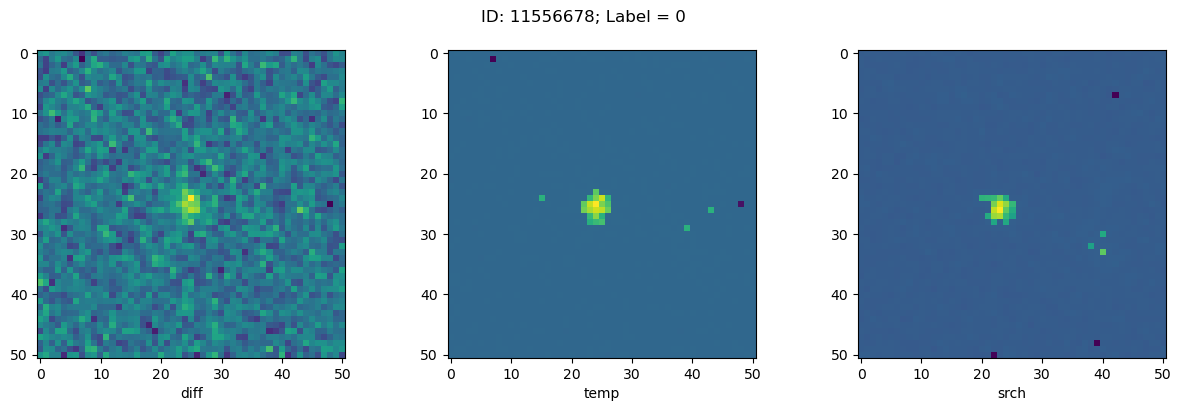

In [7]:
#visual check, make sure all is well :)

testnum = 19246
testimg = imageArray[testnum]
testlabel = labelArray[testnum]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].imshow(testimg[:,:,0])
axes[0].set_xlabel('diff')
axes[1].imshow(testimg[:,:,1])
axes[1].set_xlabel('temp')
axes[2].imshow(testimg[:,:,2])
axes[2].set_xlabel('srch')

fig.suptitle(f"ID: {testlabel[0]}; Label = {testlabel[1]}")
plt.show()

In [11]:
cropshape = (25,25)
centreCroppedArray = np.zeros((imageArray.shape[0], cropshape[0], cropshape[1], imageArray.shape[3]))
for i, triplet in enumerate(tqdm.tqdm(imageArray)):
    centreCroppedArray[i] = centredCrop(triplet)

100%|██████████| 89436/89436 [00:01<00:00, 86871.17it/s]


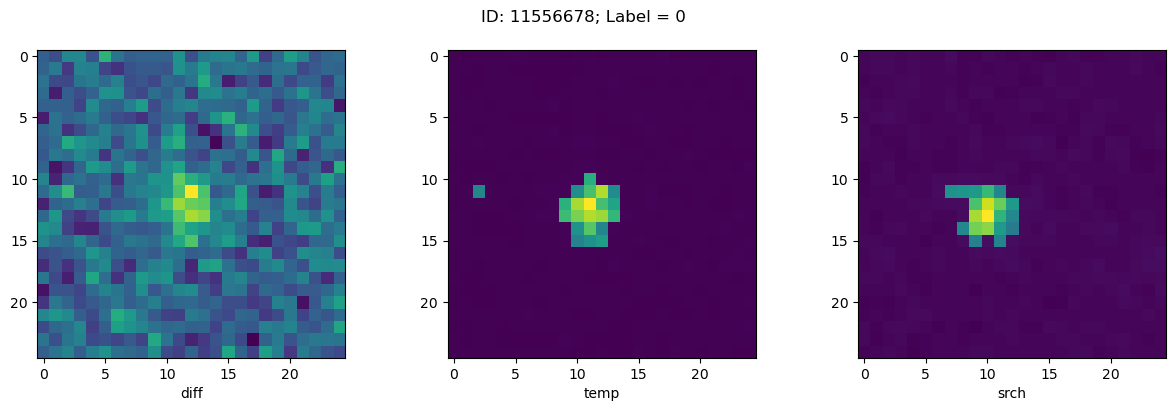

In [12]:
#visual check again

testcrop = centreCroppedArray[testnum]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].imshow(testcrop[:,:,0])
axes[0].set_xlabel('diff')
axes[1].imshow(testcrop[:,:,1])
axes[1].set_xlabel('temp')
axes[2].imshow(testcrop[:,:,2])
axes[2].set_xlabel('srch')

fig.suptitle(f"ID: {testlabel[0]}; Label = {testlabel[1]}")
plt.show()

In [13]:
randomCroppedArray = np.zeros((imageArray.shape[0], cropshape[0], cropshape[1], imageArray.shape[3]))
for i, triplet in enumerate(tqdm.tqdm(imageArray)):
    randomCroppedArray[i] = randomCrop(triplet)

100%|██████████| 89436/89436 [00:03<00:00, 24772.30it/s]


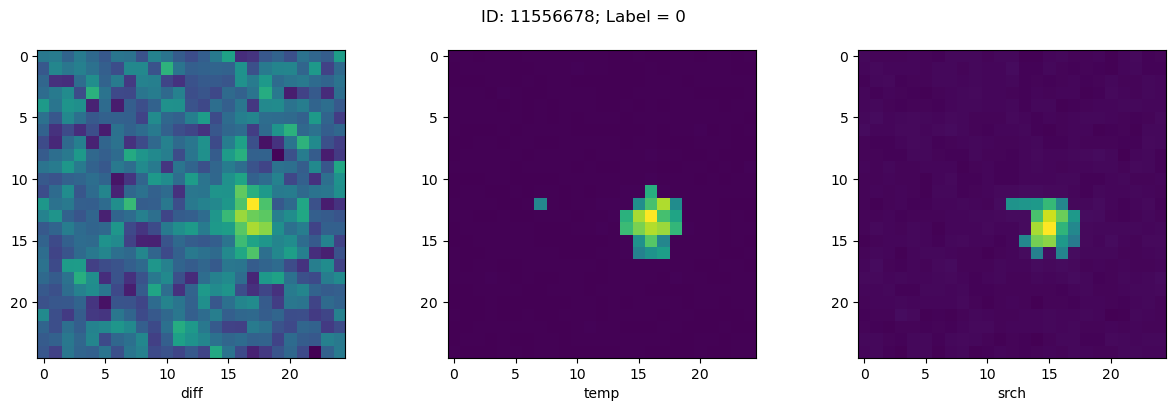

In [14]:
#visual check again

testcrop = randomCroppedArray[testnum]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].imshow(testcrop[:,:,0])
axes[0].set_xlabel('diff')
axes[1].imshow(testcrop[:,:,1])
axes[1].set_xlabel('temp')
axes[2].imshow(testcrop[:,:,2])
axes[2].set_xlabel('srch')

fig.suptitle(f"ID: {testlabel[0]}; Label = {testlabel[1]}")
plt.show()

100%|██████████| 89436/89436 [00:04<00:00, 19809.22it/s]


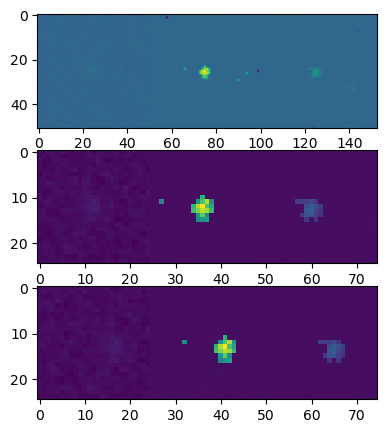

In [16]:
#and finally, horizontally stack!
data = np.zeros((imageArray.shape[0], imageArray.shape[1], imageArray.shape[2]*imageArray.shape[3]))
centreCropData = np.zeros((centreCroppedArray.shape[0], centreCroppedArray.shape[1], 
                           centreCroppedArray.shape[2]*centreCroppedArray.shape[3]))
randomCropData = np.zeros((randomCroppedArray.shape[0], randomCroppedArray.shape[1], 
                           randomCroppedArray.shape[2]*randomCroppedArray.shape[3]))

for i in tqdm.tqdm(range(len(data))):
    data[i] = hstackImages(imageArray[i])
    centreCropData[i] = hstackImages(centreCroppedArray[i])
    randomCropData[i] = hstackImages(randomCroppedArray[i])

fig, axes = plt.subplots(3, 1, figsize=(15,5))

axes[0].imshow(data[testnum])
axes[1].imshow(centreCropData[testnum])
axes[2].imshow(randomCropData[testnum])

When we plot these triplets horizontally, it looks visually like the difference image has disappeared; but looking at the pixel values in the array, they stay the same, so we can assume that it's a case of those pixel values being 'drowned out' by the more extreme values of the srch and temp images. (especially given that they are normalised differently: the diff images with mean = 0, std = 1, while temp and srch are scaled 0-->1 within 3sig boundary).

## 2. Running Different Benchmark Architectures
These subsections train different models based on architectures from previous papers, and records their results.

### Splitting data, etc. 

In [17]:
from keras import layers, models, backend
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split

Splitting data into train (70%), validation (10%), and test (20%) sets:

In [18]:
print(data.shape)
print(centreCropData.shape)
print(randomCropData.shape)

(89436, 51, 153)
(89436, 25, 75)
(89436, 25, 75)


In [19]:
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
centreCropData = centreCropData.reshape(centreCropData.shape[0], centreCropData.shape[1], 
                                        centreCropData.shape[2], 1)
randomCropData = randomCropData.reshape(randomCropData.shape[0], randomCropData.shape[1], 
                                        randomCropData.shape[2], 1)

In [21]:
labels = labelArray[:,1].astype(float)

X_train, X_nontrain, y_train, y_nontrain = train_test_split(data, labels, train_size = 0.7)
X_test, X_valid, y_test, y_valid = train_test_split(X_nontrain, y_nontrain, train_size = 2/3)

#confirm splitting is correct
assert len(y_train)+len(y_valid)+len(y_test) == len(labels)
assert np.isclose(len(y_test)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(y_valid)/len(labels), 0.1, rtol=0.01)

X_train_centre_crop, X_nontrain_centre_crop, y_train_centre_crop, y_nontrain_centre_crop = train_test_split(centreCropData, labels, train_size = 0.7)
X_test_centre_crop, X_valid_centre_crop, y_test_centre_crop, y_valid_centre_crop = train_test_split(X_nontrain_centre_crop, y_nontrain_centre_crop, train_size = 2/3)

#confirm splitting is correct
assert len(y_train_centre_crop)+len(y_valid_centre_crop)+len(y_test_centre_crop) == len(labels)
assert np.isclose(len(y_test_centre_crop)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(y_valid_centre_crop)/len(labels), 0.1, rtol=0.01)

X_train_random_crop, X_nontrain_random_crop, y_train_random_crop, y_nontrain_random_crop = train_test_split(randomCropData, labels, train_size = 0.7)
X_test_random_crop, X_valid_random_crop, y_test_random_crop, y_valid_random_crop = train_test_split(X_nontrain_random_crop, y_nontrain_random_crop, train_size = 2/3)

#confirm splitting is correct
assert len(y_train_random_crop)+len(y_valid_random_crop)+len(y_test_random_crop) == len(labels)
assert np.isclose(len(y_test_random_crop)/len(labels), 0.2, rtol=0.01) 
assert np.isclose(len(y_valid_random_crop)/len(labels), 0.1, rtol=0.01)

### a. Acero-Cuellar Architecture: centred images
Using X_train, X_test, X_valid alongside y_train, y_test, y_valid

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(16, (5,5), activation='relu', padding='valid', input_shape=(51, 153,1)))
model.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model.add(layers.Conv2D(32, (5,5), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2), strides = 2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (5,5), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 149, 16)       416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 70, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 35, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 35, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 31, 64)         5

2023-06-17 09:34:56.643582: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 128. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

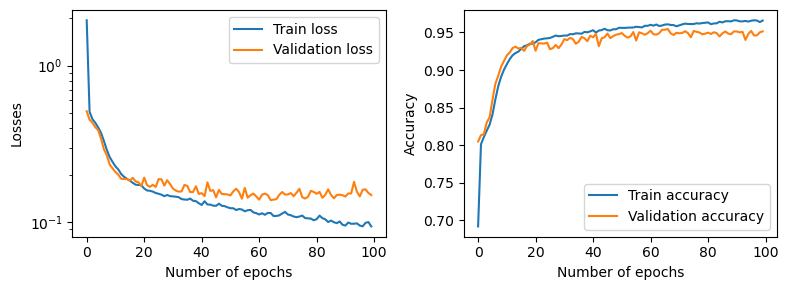

123/123 [==============================] - 68s 556ms/step - loss: 0.0942 - accuracy: 0.9658 - val_loss: 0.1493 - val_accuracy: 0.9515


In [15]:
saveFileName1 = 'model_benchmark_ACarchitecture_incldiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model.fit(X_train, y_train, 
              batch_size=512, epochs=100, 
              validation_data=(X_valid, y_valid), 
              verbose=1, callbacks=[plot_losses])
    
    model.save(saveFileName1)
    
model = load_model(saveFileName1)

### b. Acero-Cuellar Architecture: cropped images
Using X_train_random_crop, X_test_random_crop, X_valid_random_crop alongside y_train_random_crop, y_test_random_crop, y_valid_random_crop

In [16]:
backend.clear_session()

In [17]:
model2 = models.Sequential()

model2.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,75,1)))
model2.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model2.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D((2,2), strides = 2))
model2.add(layers.Dropout(0.3))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D((2,2), strides=2))
model2.add(layers.Dropout(0.3))

model2.add(layers.Flatten())
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 75, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 35, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 17, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 17, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 15, 64)         1

In [18]:
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [19]:
X_valid_random_crop.shape

(8944, 25, 75, 1)

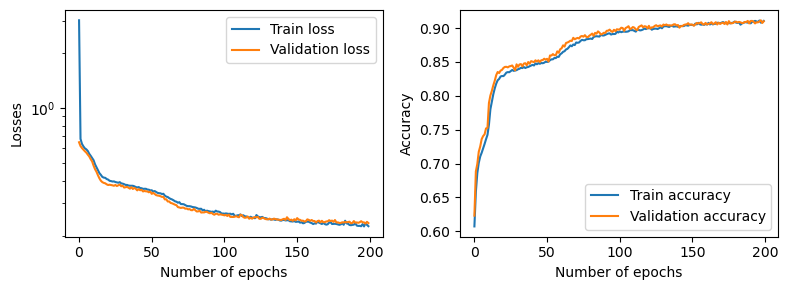

123/123 [==============================] - 15s 118ms/step - loss: 0.2251 - accuracy: 0.9105 - val_loss: 0.2341 - val_accuracy: 0.9100


In [20]:
saveFileName2 = 'model_benchmark_ACarchitecture_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model2.fit(X_train_random_crop, y_train_random_crop, 
               batch_size=512, epochs=200, 
               validation_data=(X_valid_random_crop, y_valid_random_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model2.save(saveFileName2)
    
model2 = load_model(saveFileName2)

### c. Acero-Cuellar Architecture: search temp input only, cropped images
Using X_train_random_crop, X_test_random_crop, X_valid_random_crop alongside y_train_random_crop, y_test_random_crop, y_valid_random_crop, notably indexed at [:, :, 25:] (to only include right two thirds, e.g. temp and srch images)

In [21]:
backend.clear_session()

In [22]:
model3 = models.Sequential()

model3.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,50,1)))
model3.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model3.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model3.add(layers.MaxPooling2D((2,2), strides = 2))
model3.add(layers.Dropout(0.3))
model3.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model3.add(layers.MaxPooling2D((2,2), strides=2))
model3.add(layers.Dropout(0.3))

model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 23, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 11, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 11, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 9, 64)          1

In [23]:
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [27]:
print(X_valid_random_crop[:,:,25:].shape)
print(y_train_random_crop.shape)

(8944, 25, 50, 1)
(62605,)


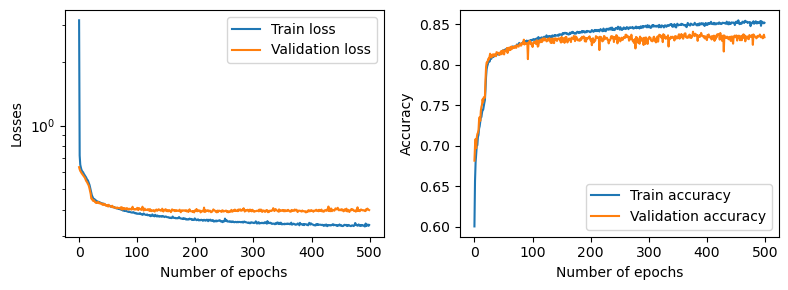

123/123 [==============================] - 10s 82ms/step - loss: 0.3379 - accuracy: 0.8519 - val_loss: 0.3979 - val_accuracy: 0.8341


In [28]:
saveFileName3 = 'model_benchmark_ACarchitecture_crop_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model3.fit(X_train_random_crop[:,:,25:], y_train_random_crop, 
               batch_size=512, epochs=500, 
               validation_data=(X_valid_random_crop[:,:,25:], y_valid_random_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model3.save(saveFileName3)
    
model3 = load_model(saveFileName3)

## 3. Testing Translation Invariance
Convnets are supposedly translation invariant, meaning that once they have been trained and have learnt a specific pattern, they can recognise it anywhere in the given field. 

This subsection examines how well this works for our given dataset, to consider whether it is worth (a) building a convenet that is *better* at recognising patterns that have been translated; and (b) building a convnet that also allows for rotational variance (e.g. a Group Equivariant Convnet, as per Cohen and Welling, https://arxiv.org/abs/1602.07576)

### a. Acero-Cuellar Architecture: search temp input only, (centred) cropped images
This test uses the same model as in section 2c, however it trains and validates on the CENTRED cropped images, before then running tests on the randomly cropped images to see how their accuracy rates compare. 

AFTER RUNNING:
Clearly, this model is *not* translationally invariant: a model trained on centred images, tested on images that *aren't* centred, has an accuracy of ~56% ; essentially not useful. 

Questions: would training the model for longer improve it's ability to recognise the same patterns, translated? (I don't know why it would...) Is there a feature of this specific architecture that doesn;t allow for 

In [22]:
backend.clear_session()

In [23]:
model4 = models.Sequential()

model4.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(25,50,1)))
model4.add(layers.MaxPooling2D((2,2), strides = 2))
#paper says dropout here, but github code seems like there's none, so skipping for now!
model4.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D((2,2), strides = 2))
model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(64, (3,3), activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D((2,2), strides=2))
model4.add(layers.Dropout(0.3))

model4.add(layers.Flatten())
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 23, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 11, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 11, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 9, 64)          1

2023-06-20 09:20:34.883933: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 128. Tune using inter_op_parallelism_threads for best performance.


In [24]:
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [25]:
print(X_valid_centre_crop[:,:,25:].shape)
print(y_train_centre_crop.shape)

(8944, 25, 50, 1)
(62605,)


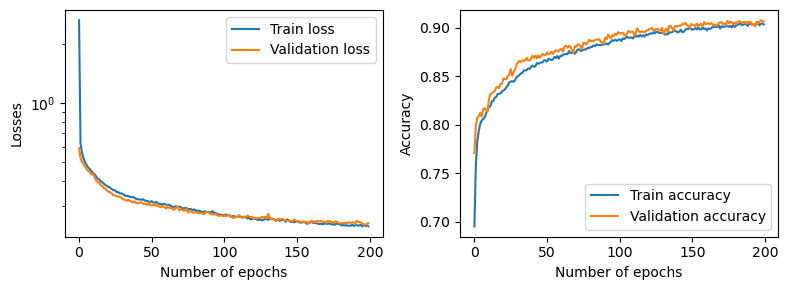

123/123 [==============================] - 10s 80ms/step - loss: 0.2351 - accuracy: 0.9032 - val_loss: 0.2438 - val_accuracy: 0.9064


In [26]:
saveFileName4 = 'model_benchmark_ACarchitecture_CENTREDcrop_nodiff.keras'

if False: #change to if False once trained properly !
    
    plot_losses = PlotLosses()
    model4.fit(X_train_centre_crop[:,:,25:], y_train_centre_crop, 
               batch_size=512, epochs=200, #reduced to 200 bc it seemed to plateau here...
               validation_data=(X_valid_centre_crop[:,:,25:], y_valid_centre_crop), 
               verbose=1, callbacks=[plot_losses])
    
    model4.save(saveFileName4)
    
model4 = load_model(saveFileName4)

#### Testing predictions here!

##### i. Testing against other cropped, centred images

559/559 [==============================] - 1s 2ms/step


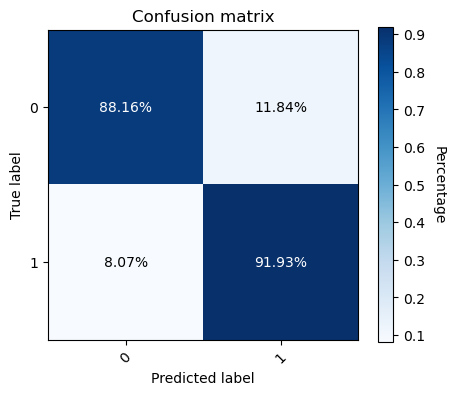

Accuracy: 90.03%
Precision: 88.40%
Recall: 91.93%


In [35]:
y_centre_pred = model4.predict(X_test_centre_crop[:,:,25:]).T[0]
y_centre_pred_binary = (y_centre_pred > 0.5).astype(int)

acc = accuracy_score(y_test_centre_crop, y_centre_pred_binary)
precision = precision_score(y_test_centre_crop, y_centre_pred_binary)
recall = recall_score(y_test_centre_crop, y_centre_pred_binary)

fig, ax = plt.subplots(figsize=(5,5))
plotConfMatrix(fig, ax, y_test_centre_crop, y_centre_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

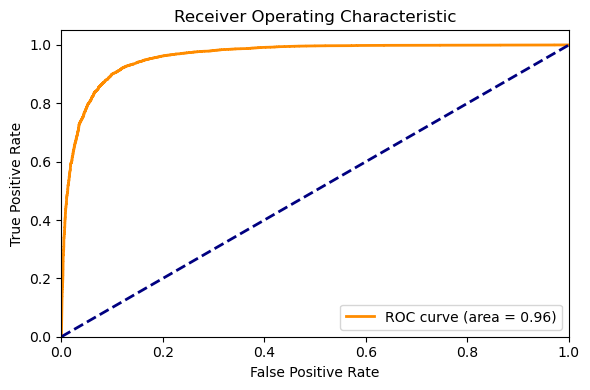

In [40]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, y_centre_pred, X_test_centre_crop[:,:,25:], y_test_centre_crop)

##### ii. Testing against RANDOMLY cropped images!

559/559 [==============================] - 1s 2ms/step


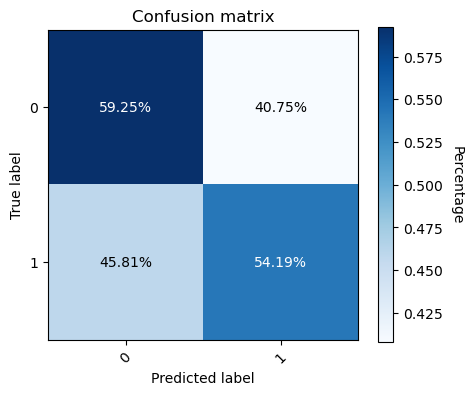

Accuracy: 56.73%
Precision: 56.75%
Recall: 54.19%


In [41]:
y_random_pred = model4.predict(X_test_random_crop[:,:,25:]).T[0]
y_random_pred_binary = (y_random_pred > 0.5).astype(int)

acc = accuracy_score(y_test_random_crop, y_random_pred_binary)
precision = precision_score(y_test_random_crop, y_random_pred_binary)
recall = recall_score(y_test_random_crop, y_random_pred_binary)

fig, ax = plt.subplots(figsize=(5,5))
plotConfMatrix(fig, ax, y_test_random_crop, y_random_pred_binary)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

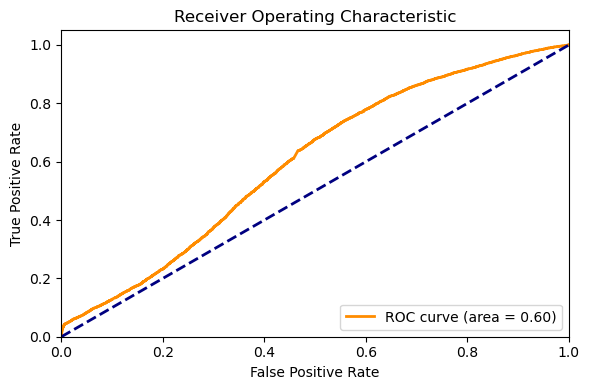

In [42]:
fig, ax = plt.subplots(figsize=(6,4))
plot_roc(fig, ax, y_random_pred, X_test_random_crop[:,:,25:], y_test_random_crop)